In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.metrics import accuracy_score
import seaborn as sns

In [46]:
df = pd.read_csv('Obesity_level_prediction_dataset.csv')
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


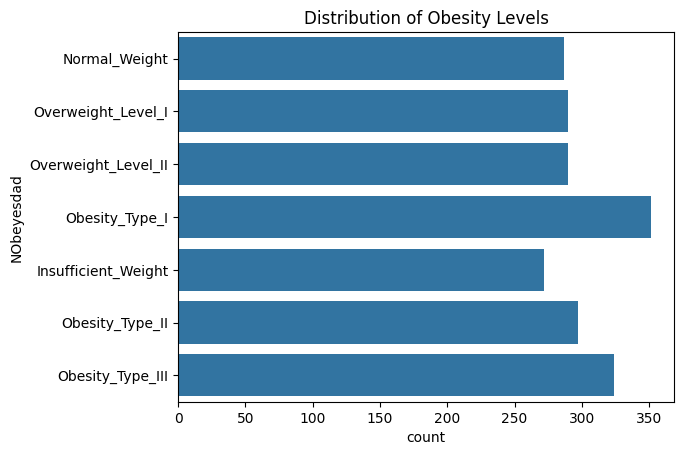

In [47]:
# exploratory data analysis to visualize the target variable distribution
# creates a frequency count bar plots, y for horizontal bar, x for vertical
sns.countplot(y='NObeyesdad', data=df)
plt.title('Distribution of Obesity Levels')
plt.show()

In [48]:
# checking for null values
print(df.isna().sum())
# dataset summary
print(df.info())
print(df.describe())


Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height             

In [49]:
# Preprocessing the data
# feature scaling
continuous_columns = df.select_dtypes(include=['float64']).columns

scaler = StandardScaler()
# .fit_transfrom gives numpy array, we then store it to a new variable standardized_continuous_columns
standardized_continuous_columns = scaler.fit_transform(df[continuous_columns])
# use use the get_feature_names_out to extract it's columns name and convert the standardized_continuous_columns into a dataframe
standardized_vectors_df = pd.DataFrame(standardized_continuous_columns, columns=scaler.get_feature_names_out(continuous_columns))
standardized_vectors_df.head()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
0,-0.522124,-0.875589,-0.862558,-0.785019,0.404153,-0.013073,-1.188039,0.561997
1,-0.522124,-1.947599,-1.168077,1.088342,0.404153,1.618759,2.339750,-1.080625
2,-0.206889,1.054029,-0.366090,-0.785019,0.404153,-0.013073,1.163820,0.561997
3,0.423582,1.054029,0.015808,1.088342,0.404153,-0.013073,1.163820,-1.080625
4,-0.364507,0.839627,0.122740,-0.785019,-2.167023,-0.013073,-1.188039,-1.080625


In [50]:
# one hot encoding for just the independent variables with type object
categorical_columns = df.select_dtypes(include=['object']).columns.drop('NObeyesdad')

# using drop='first' which removes multicolinearity meaning remove redundancy during one hot encoding
# sparse_output=False gives numpy array, default is True which gives us a sparse matrix that stores only non-zero values (memory efficient)
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_vectors = encoder.fit_transform(df[categorical_columns])

# since one hot encoder returns numpy array instead of dataframe, we need to convert it back to dataframe to include it with the feature vectors
encoded_vectors_df = pd.DataFrame(encoded_vectors, columns=encoder.get_feature_names_out(categorical_columns))
encoded_vectors_df.head()


,Gender_Male,family_history_with_overweight_yes,FAVC_yes,CAEC_Frequently,CAEC_Sometimes,CAEC_no,SMOKE_yes,SCC_yes,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [51]:
# now combining both standardized_vectors_df and encoded_vectors_df
input_data = pd.concat([standardized_vectors_df, encoded_vectors_df], axis=1)
input_data.head()
target_data = df[['NObeyesdad']].copy()
target_data.head()

,NObeyesdad
0,Normal_Weight
1,Normal_Weight
2,Normal_Weight
3,Overweight_Level_I
4,Overweight_Level_II


In [52]:
# first convert the NObeyesdad into categories and use cat.codes to generate codes for each category of value
target_data['NObeyesdad'] = target_data['NObeyesdad'].astype('category').cat.codes
target_data.head()

,NObeyesdad
0,1
1,1
2,1
3,5
4,6


In [53]:
X = input_data
# converting the target value into 1d array
y = target_data['NObeyesdad'].values

In [54]:
# train test split
# using stratify True here because the of imbalanced dataset to sure the training and testing dataset are proportional
# based on the target dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [56]:
# using one vs all (ova) also known as one vs rest classifier to classify
model_ova = OneVsRestClassifier(LogisticRegression(max_iter=1000))
model_ova.fit(X_train, y_train)

OneVsRestClassifier(estimator=LogisticRegression(max_iter=1000))

In [70]:
# evaluate the result
y_pred_ova = model_ova.predict(X_test)

# evaluation mertic for ova
print(f'Accuracy: {np.round(100 * accuracy_score(y_test,y_pred_ova), 2)}%')

Accuracy: 76.12%


In [72]:
# using one vs one (ovo) to classify
model_ovo = OneVsOneClassifier(LogisticRegression(max_iter=1000))
model_ovo.fit(X_train, y_train)

y_pred_ovo = model_ovo.predict(X_test)
print(f'Accuracy: {np.round(100 * accuracy_score(y_test, y_pred_ovo), 2)}%')

Accuracy: 92.2%
